In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.metrics import Loss
from ignite.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm

In [2]:
DATA_PATH = "../../data/combined_tripdata.csv"
INPUT_SEQUENCE_LENGTH = 30
OUTPUT_SEQUENCE_LENGTH = 1

PATIENCE = 3
NUM_EPOCHS = 20

PERFORM_TUNING = False
NUM_TRIALS = 30
params = {
    'model_type': 'lstm',
    'hidden_size': 256,
    'num_layers': 3,
    'dropout': 0.3,
    'learning_rate': 0.00064,
    'batch_size': 128,
    'weight_decay': 1.12041e-6
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Preprocessor:
    MINIMUM_TRAIN_DAYS = 365

    columns_to_load = [
        'started_at', 'start_station_id', 'start_lat', 'start_lng',
    ]
    date_columns = ['started_at']

    train_dataset = None
    val_dataset = None
    test_dataset = None

    def preprocess_data(self, data_path: str, train_proportion: float = 0.6,
                        validation_proportion: float = 0.2,
                        input_sequence_length: int = 30, output_sequence_length: int = 1):
        # Load Data
        data = pd.read_csv(data_path, usecols=self.columns_to_load, parse_dates=self.date_columns)
        data['start_station_id'] = data['start_station_id'].astype('string')
        data['date'] = pd.to_datetime(data['started_at'], errors='coerce').dt.date
        data.rename(columns={'start_station_id': 'station_id', 'start_lat': 'latitude', 'start_lng': 'longitude'},
                    inplace=True)
        data.dropna(inplace=True)

        # Standardize coordinates
        station_coords = data.groupby('station_id').agg({'latitude': 'median', 'longitude': 'median'}).reset_index()
        data = data.merge(station_coords, on='station_id', how='left', suffixes=('_orig', ''))
        data.drop(['latitude_orig', 'longitude_orig'], axis=1, inplace=True)

        # Group to get counts
        data = data.groupby(['station_id', 'latitude', 'longitude', 'date']).size().reset_index(name='count')

        # Encoding
        label_encoder = LabelEncoder()
        data['station_id'] = label_encoder.fit_transform(data['station_id'])

        data['date'] = pd.to_datetime(data['date'])
        data['day_of_week'] = data['date'].dt.weekday
        data['day_of_month'] = data['date'].dt.day
        data['month'] = data['date'].dt.month
        data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
        data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
        data['day_of_month_sin'] = np.sin(2 * np.pi * data['day_of_month'] / 31)
        data['day_of_month_cos'] = np.cos(2 * np.pi * data['day_of_month'] / 31)
        data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
        data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
        data.drop(['day_of_week', 'day_of_month', 'month'], axis=1, inplace=True)

        # Remove stations outside training
        train_rows = int(len(data) * train_proportion)
        train_subset = data.iloc[:train_rows]
        train_subset = train_subset.groupby('station_id').size().reset_index(name='count')
        station_ids_to_include = train_subset[train_subset['count'] > self.MINIMUM_TRAIN_DAYS]['station_id'].tolist()
        data = data[data['station_id'].isin(station_ids_to_include)]

        # Split data
        train, x_temp = train_test_split(data, train_size=train_proportion, shuffle=False)
        val, test = train_test_split(x_temp, train_size=validation_proportion / (1 - train_proportion), shuffle=False)
        scaler = StandardScaler()
        scaler.fit(train.drop('date', axis=1))

        # Create sequences
        x_train, y_train = self.create_sequences(train, scaler, seq_length=input_sequence_length,
                                                 target_length=output_sequence_length)
        x_val, y_val = self.create_sequences(val, scaler, seq_length=input_sequence_length,
                                             target_length=output_sequence_length)
        x_test, y_test = self.create_sequences(test, scaler, seq_length=input_sequence_length,
                                               target_length=output_sequence_length)

        # Convert to tensors
        self.train_dataset = data_utils.TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
        self.val_dataset = data_utils.TensorDataset(torch.FloatTensor(x_val), torch.FloatTensor(y_val))
        self.test_dataset = data_utils.TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

    @staticmethod
    def create_sequences(data: pd.DataFrame, scaler: StandardScaler, seq_length: int, target_length: int):
        x, y = [], []
        station_ids = data['station_id'].unique()
        for station_id in tqdm(station_ids):
            x_data = data[data['station_id'] == station_id].sort_values('date', ascending=True)
            x_data.drop(['date'], axis=1, inplace=True)
            y_data = x_data[['count']]

            x_values = scaler.transform(x_data)
            y_values = y_data.values

            for i in range(len(x_data) - seq_length - target_length + 1):
                x.append(x_values[i:(i + seq_length)])
                y.append(y_values[(i + seq_length):(i + seq_length + target_length)])

        return np.array(x), np.array(y)

    def get_loaders(self, batch_size: int):
        train_loader = data_utils.DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = data_utils.DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = data_utils.DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

In [4]:
# Preprocessing
preprocessor = Preprocessor()
preprocessor.preprocess_data(DATA_PATH, input_sequence_length=INPUT_SEQUENCE_LENGTH,
                             output_sequence_length=OUTPUT_SEQUENCE_LENGTH)
input_size = preprocessor.train_dataset.tensors[0].shape[2]
output_size = preprocessor.train_dataset.tensors[1].shape[2]

C:\Users\Doug\AppData\Local\Temp\ipykernel_35796\514216289.py:17: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path, usecols=self.columns_to_load, parse_dates=self.date_columns)


Empty values: started_at          0
station_id    3465171
latitude            0
longitude           0
date          4166326
dtype: int64


100%|██████████| 91/91 [00:00<00:00, 517.49it/s]


In [5]:
class ModelEvaluator:
    def __init__(self, model):
        self.model = model
        self.device = next(model.parameters()).device

    def create_evaluator(self):

        def evaluation_step(engine, batch):
            self.model.eval()
            with torch.no_grad():
                x, y = batch
                x = x.to(self.device)
                y = y.to(self.device)
                y_pred = self.model(x)
                return y_pred, y

        evaluator = Engine(evaluation_step)

        metrics = {
            'mse': MeanSquaredError(),
            'rmse': RootMeanSquaredError(),
            'mae': MeanAbsoluteError()
        }

        for name, metric in metrics.items():
            metric.attach(evaluator, name)

        return evaluator

    def evaluate(self, test_loader):
        self.model.eval()
        predictions = []
        targets = []

        evaluator = self.create_evaluator()
        evaluator.run(test_loader)

        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(self.device)
                y_pred = self.model(x)
                predictions.append(y_pred.cpu().numpy())
                targets.append(y.numpy())

        predictions = np.concatenate(predictions)
        targets = np.concatenate(targets)

        return targets, predictions

    def calculate_metrics(self, targets, predictions):
        targets_2d = targets.reshape(-1, targets.shape[-1])
        predictions_2d = predictions.reshape(-1, predictions.shape[-1])

        mse = mean_squared_error(targets_2d, predictions_2d)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(targets_2d, predictions_2d)

        metrics = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae
        }

        print("\nModel Evaluation Metrics:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")

        return metrics

    def plot_predictions(self, targets, predictions):
        plt.figure(figsize=(10, 6))

        targets_flat = targets.reshape(-1)
        predictions_flat = predictions.reshape(-1)

        plt.scatter(targets_flat, predictions_flat, alpha=0.5, s=1)

        max_val = max(targets_flat.max(), predictions_flat.max())
        min_val = min(targets_flat.min(), predictions_flat.min())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Predicted vs Actual Values')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

In [6]:
class StationTrafficModel(nn.Module):
    def __init__(self, model_type, input_size, hidden_size, output_size, output_sequence_length, num_layers, dropout):
        super(StationTrafficModel, self).__init__()
        self.model_type = model_type.lower()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_sequence_length = output_sequence_length
        self.output_size = output_size

        if self.model_type == 'lstm':
            self.encoder = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        elif self.model_type == 'gru':
            self.encoder = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                batch_first=True
            )
        else:
            raise ValueError("model_type must be either 'lstm' or 'gru'")

        self.decoder = nn.GRU(
            input_size=output_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )

        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        if self.model_type == 'lstm':
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            _, (hidden, _) = self.encoder(x, (h0, c0))
        else:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            _, hidden = self.encoder(x, h0)

        decoder_hidden = hidden[-1].unsqueeze(0)
        decoder_input = torch.zeros(batch_size, 1, self.output_size).to(x.device)
        outputs = []

        for _ in range(self.output_sequence_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            prediction = self.output_layer(decoder_output)
            outputs.append(prediction)
            decoder_input = prediction

        return torch.cat(outputs, dim=1)

    def train_model(self, criterion, optimizer, train_loader, val_loader, num_epochs, patience, device):
        self.to(device)

        trainer = create_supervised_trainer(self, optimizer, criterion, device=device)
        evaluator = create_supervised_evaluator(
            self,
            metrics={'loss': Loss(criterion)},
            device=device
        )
        history = {'train_loss': [], 'val_loss': []}

        pbar = ProgressBar()
        pbar.attach(trainer)

        checkpoint_handler = ModelCheckpoint(
            'checkpoints',
            'best_model',
            n_saved=1,
            require_empty=False,
            score_function=lambda engine: -engine.state.metrics['loss'],
            score_name='val_loss'
        )
        evaluator.add_event_handler(Events.COMPLETED, checkpoint_handler, {'model': self})

        early_stopping = EarlyStopping(
            patience=patience,
            score_function=lambda engine: -engine.state.metrics['loss'],
            trainer=trainer
        )
        evaluator.add_event_handler(Events.COMPLETED, early_stopping)

        @trainer.on(Events.EPOCH_COMPLETED)
        def log_training_results(engine):
            evaluator.run(train_loader)
            metrics = evaluator.state.metrics
            train_loss = metrics['loss']
            history['train_loss'].append(train_loss)
            pbar.log_message(f"Epoch [{engine.state.epoch}/{num_epochs}] Train Loss: {train_loss}")

        @trainer.on(Events.EPOCH_COMPLETED)
        def log_validation_results(engine):
            evaluator.run(val_loader)
            metrics = evaluator.state.metrics
            val_loss = metrics['loss']
            history['val_loss'].append(val_loss)
            pbar.log_message(f"Epoch [{engine.state.epoch}/{num_epochs}] Validation Loss: {val_loss}")

        trainer.run(train_loader, max_epochs=num_epochs)

        best_model_path = checkpoint_handler.last_checkpoint
        if best_model_path:
            self.load_state_dict(torch.load(best_model_path))

        return self, history

In [7]:
def objective(trial, input_size: int, output_size, output_sequence_length, patience, num_epochs, preprocessor,
              device):
    model_type = trial.suggest_categorical('model_type', ['lstm', 'gru'])
    hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.0, 0.5, step=0.05)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64, 128, 256])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-1, log=True)

    train_loader, val_loader, _ = preprocessor.get_loaders(batch_size)
    model = StationTrafficModel(model_type, input_size, hidden_size, output_size,
                                output_sequence_length, num_layers,
                                dropout)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train_model(criterion, optimizer, train_loader, val_loader, num_epochs, patience, device)
    evaluator = ModelEvaluator(model)
    targets, predictions = evaluator.evaluate(val_loader)
    metrics = evaluator.calculate_metrics(targets, predictions)

    return metrics['mse']

In [8]:
# Hyperparameter Tuning
if PERFORM_TUNING:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, input_size, output_size,
                                           OUTPUT_SEQUENCE_LENGTH, PATIENCE, NUM_EPOCHS, preprocessor, device),
                   n_trials=NUM_TRIALS)
    print("Best hyperparameters:", study.best_params)
    params = params | study.best_params

In [9]:
# Training
train_loader, val_loader, test_loader = preprocessor.get_loaders(params['batch_size'])
model = StationTrafficModel(params['model_type'], input_size, params['hidden_size'],
                            output_size,
                            OUTPUT_SEQUENCE_LENGTH, params['num_layers'],
                            params['dropout'])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
model.train_model(criterion, optimizer, train_loader, val_loader, NUM_EPOCHS, PATIENCE, device)

[1/1598]   0%|           [00:00<?]

Epoch [1/20] Train Loss: 606.4524662010135
Epoch [1/20] Validation Loss: 48.9383379721075


[1/1598]   0%|           [00:00<?]

Epoch [2/20] Train Loss: 458.16982645614445
Epoch [2/20] Validation Loss: 43.8902181720237


[1/1598]   0%|           [00:00<?]

Epoch [3/20] Train Loss: 375.1783373442116
Epoch [3/20] Validation Loss: 44.090104447237685


[1/1598]   0%|           [00:00<?]

2025-02-23 12:29:27,641 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch [4/20] Train Loss: 338.10377413863944
Epoch [4/20] Validation Loss: 41.09146615191237


(StationTrafficModel(
   (encoder): LSTM(10, 256, num_layers=3, batch_first=True, dropout=0.3)
   (decoder): GRU(1, 256, batch_first=True)
   (output_layer): Linear(in_features=256, out_features=1, bias=True)
 ),
 {'train_loss': [606.4524662010135,
   458.16982645614445,
   375.1783373442116,
   338.10377413863944],
  'val_loss': [48.9383379721075,
   43.8902181720237,
   44.090104447237685,
   41.09146615191237]})


Model Evaluation Metrics:
mse: 75.1494
rmse: 8.6689
mae: 5.3998


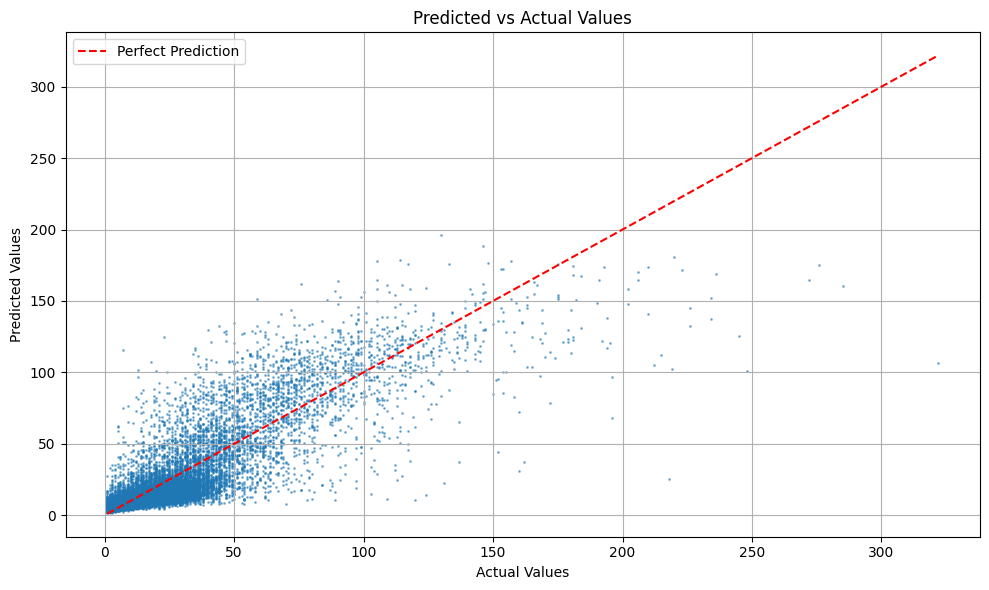

In [22]:
# Evaluation
evaluator = ModelEvaluator(model)
targets, predictions = evaluator.evaluate(test_loader)
metrics = evaluator.calculate_metrics(targets, predictions)
evaluator.plot_predictions(targets, predictions)